In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install libraries
!pip install librosa pandas matplotlib seaborn openpyxl scipy -q

print("✅ Setup complete!")

Mounted at /content/drive
✅ Setup complete!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [11]:
# Set path to shared Google Drive data
DATA_PATH = '/content/drive/MyDrive/SAND-AIProject/SAND_Challenge_task1_dataset/task1/'

# Verify path exists
if os.path.exists(DATA_PATH):
    print(f"✅ Data path found!")
    print(f"Contents: {os.listdir(DATA_PATH)}")
else:
    print(f"❌ Path not found. Check your data location.")

✅ Data path found!
Contents: ['.DS_Store', 'sand_task_1.xlsx', 'training']


In [12]:
# Load Excel file
excel_path = os.path.join(DATA_PATH, 'sand_task_1.xlsx')
df = pd.read_excel(excel_path, sheet_name='SAND - TRAINING set - Task 1')

print(f"✅ Loaded patient data!")
print(f"Total patients: {len(df)}")
print(f"\nClass distribution:")
print(df['Class'].value_counts().sort_index())

# Define recording tasks
VOWEL_TASKS = ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU']
RHYTHM_TASKS = ['rhythmPA', 'rhythmTA', 'rhythmKA']
ALL_TASKS = VOWEL_TASKS + RHYTHM_TASKS

print(f"\nRecording tasks: {ALL_TASKS}")

✅ Loaded patient data!
Total patients: 272

Class distribution:
Class
1      6
2     26
3     57
4     76
5    107
Name: count, dtype: int64

Recording tasks: ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU', 'rhythmPA', 'rhythmTA', 'rhythmKA']


In [13]:
print("\n🔍 Selecting representative patients matched by age AND gender...")

# Define target criteria
target_age = df['Age'].median()
target_gender = 'M'  # Pick M or F
age_tolerance = 5  # Within ±5 years

print(f"Criteria: Age ~{target_age:.0f} (±{age_tolerance}), Gender: {target_gender}")
print("-" * 70)

sample_patients = {}

for cls in range(1, 6):
    cls_patients = df[df['Class'] == cls].copy()

    # Filter by gender AND age range
    candidates = cls_patients[
        (cls_patients['Sex'] == target_gender) &
        (cls_patients['Age'] >= target_age - age_tolerance) &
        (cls_patients['Age'] <= target_age + age_tolerance)
    ]

    if len(candidates) > 0:
        # Among candidates, pick closest to target age
        candidates['age_diff'] = (candidates['Age'] - target_age).abs()
        patient = candidates.loc[candidates['age_diff'].idxmin()]
        match_type = "✓ Matched"
    else:
        # If strict criteria not met, relax and just match gender
        same_gender = cls_patients[cls_patients['Sex'] == target_gender]
        if len(same_gender) > 0:
            same_gender['age_diff'] = (same_gender['Age'] - target_age).abs()
            patient = same_gender.loc[same_gender['age_diff'].idxmin()]
            match_type = "~ Gender matched"
        else:
            # Last resort: closest to target age
            cls_patients['age_diff'] = (cls_patients['Age'] - target_age).abs()
            patient = cls_patients.loc[cls_patients['age_diff'].idxmin()]
            match_type = "≈ Age matched"

    sample_patients[cls] = patient['ID']

    print(f"Class {cls}: Patient {patient['ID']:>6} | Age: {patient['Age']:>2} | " +
          f"Gender: {patient['Sex']} | {match_type}")

print("-" * 70)
print(f"✅ Selected {len(sample_patients)} representative patients")


🔍 Selecting representative patients matched by age AND gender...
Criteria: Age ~64 (±5), Gender: M
----------------------------------------------------------------------
Class 1: Patient  ID261 | Age: 68 | Gender: M | ✓ Matched
Class 2: Patient  ID187 | Age: 66 | Gender: M | ✓ Matched
Class 3: Patient  ID040 | Age: 65 | Gender: M | ✓ Matched
Class 4: Patient  ID041 | Age: 65 | Gender: M | ✓ Matched
Class 5: Patient  ID068 | Age: 64 | Gender: M | ✓ Matched
----------------------------------------------------------------------
✅ Selected 5 representative patients



🔊 Creating Plot 1: Waveforms by Severity Class...


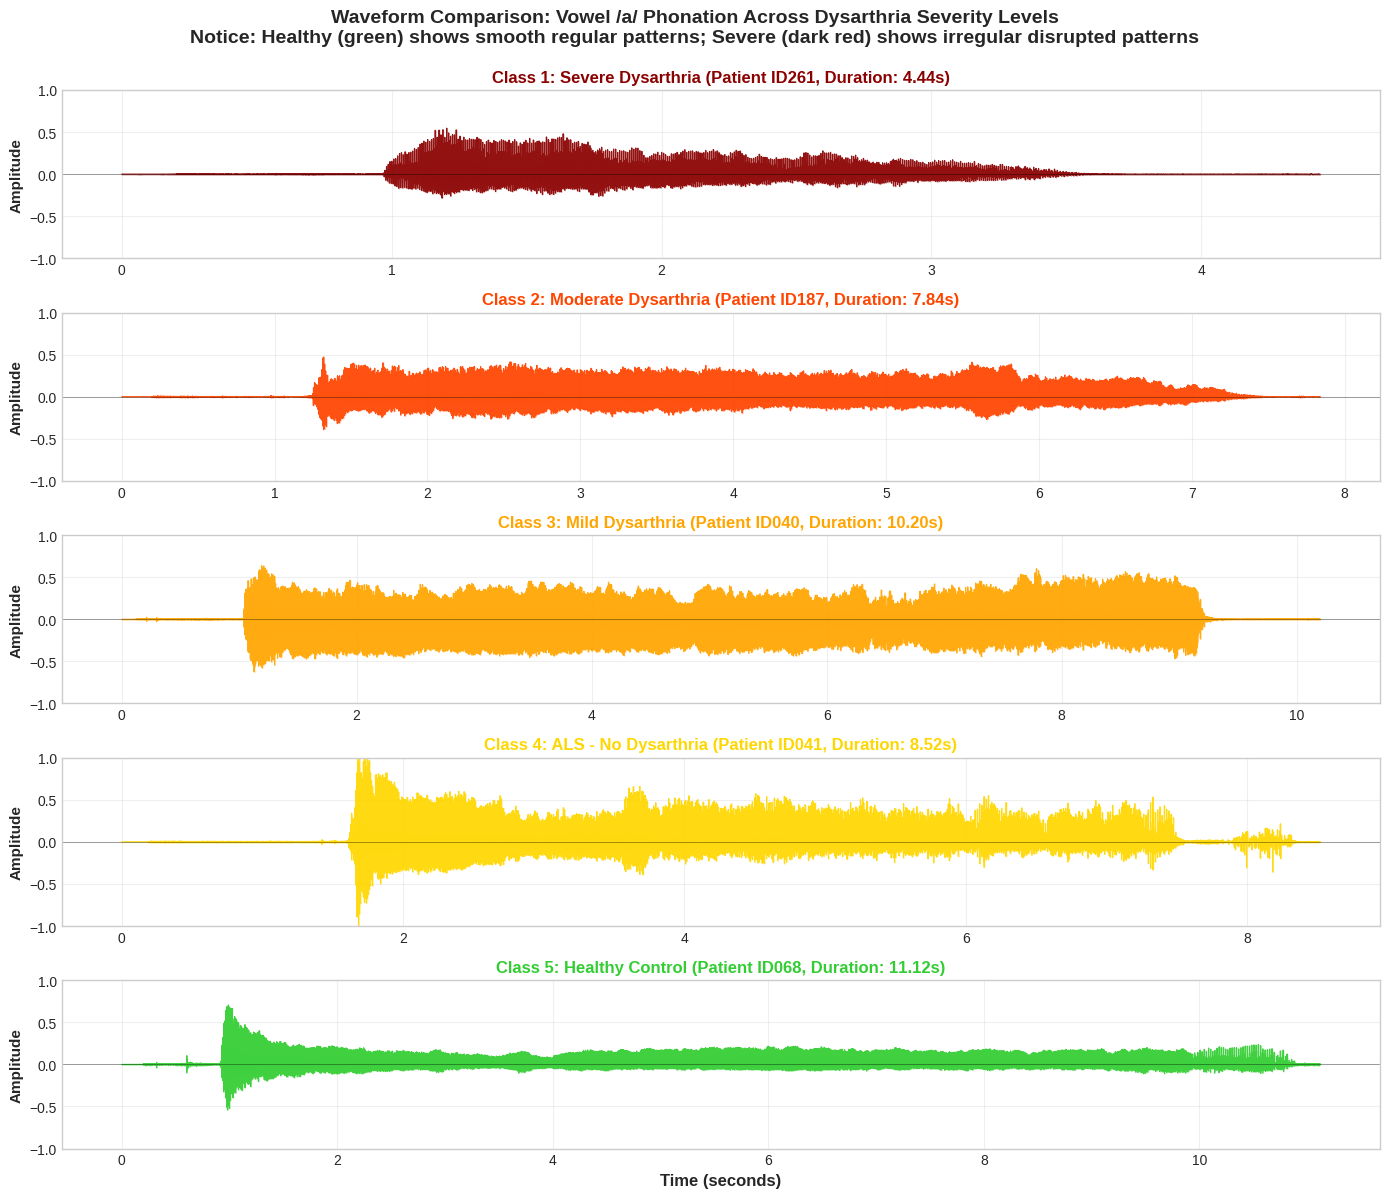

✅ Plot 1 saved: plot1_waveforms_by_severity_class.pdf


In [14]:
print("\n🔊 Creating Plot 1: Waveforms by Severity Class...")

# Create figure with 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# Color scheme for severity
colors = ['#8B0000', '#FF4500', '#FFA500', '#FFD700', '#32CD32']
class_names = {
    1: 'Severe Dysarthria',
    2: 'Moderate Dysarthria',
    3: 'Mild Dysarthria',
    4: 'ALS - No Dysarthria',
    5: 'Healthy Control'
}

# Plot waveform for each class (using phonationA)
for idx, cls in enumerate(range(1, 6)):
    patient_id = sample_patients[cls]
    audio_path = os.path.join(DATA_PATH, 'training', 'phonationA', f"{patient_id}_phonationA.wav")

    # Load audio
    try:
        audio, sr = librosa.load(audio_path, sr=8000)
        duration = len(audio) / sr
        time_axis = np.linspace(0, duration, len(audio))

        # Plot waveform
        axes[idx].plot(time_axis, audio, color=colors[idx], linewidth=0.8, alpha=0.9)
        axes[idx].fill_between(time_axis, audio, alpha=0.3, color=colors[idx])

        # Formatting
        axes[idx].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Class {cls}: {class_names[cls]} (Patient {patient_id}, Duration: {duration:.2f}s)',
                           fontsize=12, fontweight='bold', color=colors[idx])
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylim(-1, 1)
        axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

    except Exception as e:
        print(f"⚠️ Error loading audio for class {cls}: {e}")

# Set x-label only on bottom plot
axes[4].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')

# Main title
fig.suptitle('Waveform Comparison: Vowel /a/ Phonation Across Dysarthria Severity Levels\n' +
             'Notice: Healthy (green) shows smooth regular patterns; Severe (dark red) shows irregular disrupted patterns',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('plot1_waveforms_by_severity_class.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot 1 saved: plot1_waveforms_by_severity_class.pdf")


🔊 Creating Plot 2: All 8 Recording Tasks...


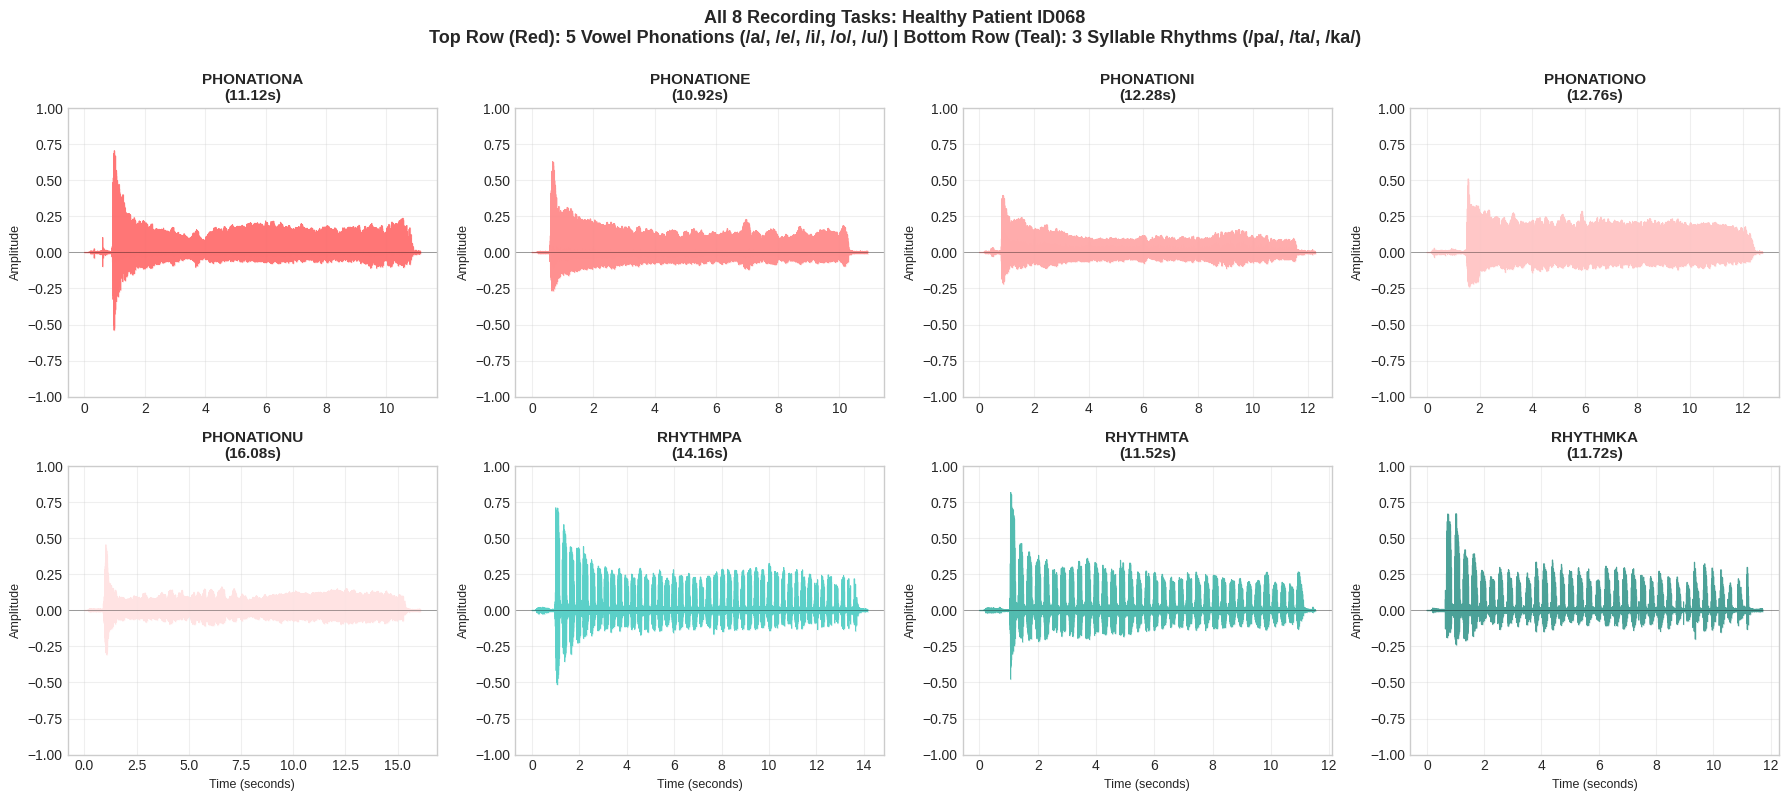

✅ Plot 2 saved: plot2_all_tasks_waveforms.pdf


In [15]:
print("\n🔊 Creating Plot 2: All 8 Recording Tasks...")

# Use healthy patient
healthy_patient = sample_patients[5]

# Create 2x4 grid (8 subplots)
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

# Task colors
task_colors = {
    'phonationA': '#FF6B6B', 'phonationE': '#FF8787', 'phonationI': '#FFA5A5',
    'phonationO': '#FFC3C3', 'phonationU': '#FFE1E1',
    'rhythmPA': '#4ECDC4', 'rhythmTA': '#45B7AA', 'rhythmKA': '#3D9A90'
}

# Plot waveform for each task
for idx, task in enumerate(ALL_TASKS):
    audio_path = os.path.join(DATA_PATH, 'training', task, f"{healthy_patient}_{task}.wav")

    try:
        audio, sr = librosa.load(audio_path, sr=8000)
        duration = len(audio) / sr
        time_axis = np.linspace(0, duration, len(audio))

        # Plot
        axes[idx].plot(time_axis, audio, color=task_colors[task], linewidth=0.7, alpha=0.9)
        axes[idx].fill_between(time_axis, audio, alpha=0.2, color=task_colors[task])

        # Format
        task_label = f"{task.upper()}\n({duration:.2f}s)"
        axes[idx].set_title(task_label, fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Amplitude', fontsize=9)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylim(-1, 1)
        axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

        # X-labels only on bottom row
        if idx >= 4:
            axes[idx].set_xlabel('Time (seconds)', fontsize=9)

    except Exception as e:
        print(f"⚠️ Error loading {task}: {e}")

fig.suptitle(f'All 8 Recording Tasks: Healthy Patient {healthy_patient}\n' +
             'Top Row (Red): 5 Vowel Phonations (/a/, /e/, /i/, /o/, /u/) | ' +
             'Bottom Row (Teal): 3 Syllable Rhythms (/pa/, /ta/, /ka/)',
             fontsize=13, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('plot2_all_tasks_waveforms.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot 2 saved: plot2_all_tasks_waveforms.pdf")


🔊 Creating Plot 3: Amplitude Envelope Analysis...


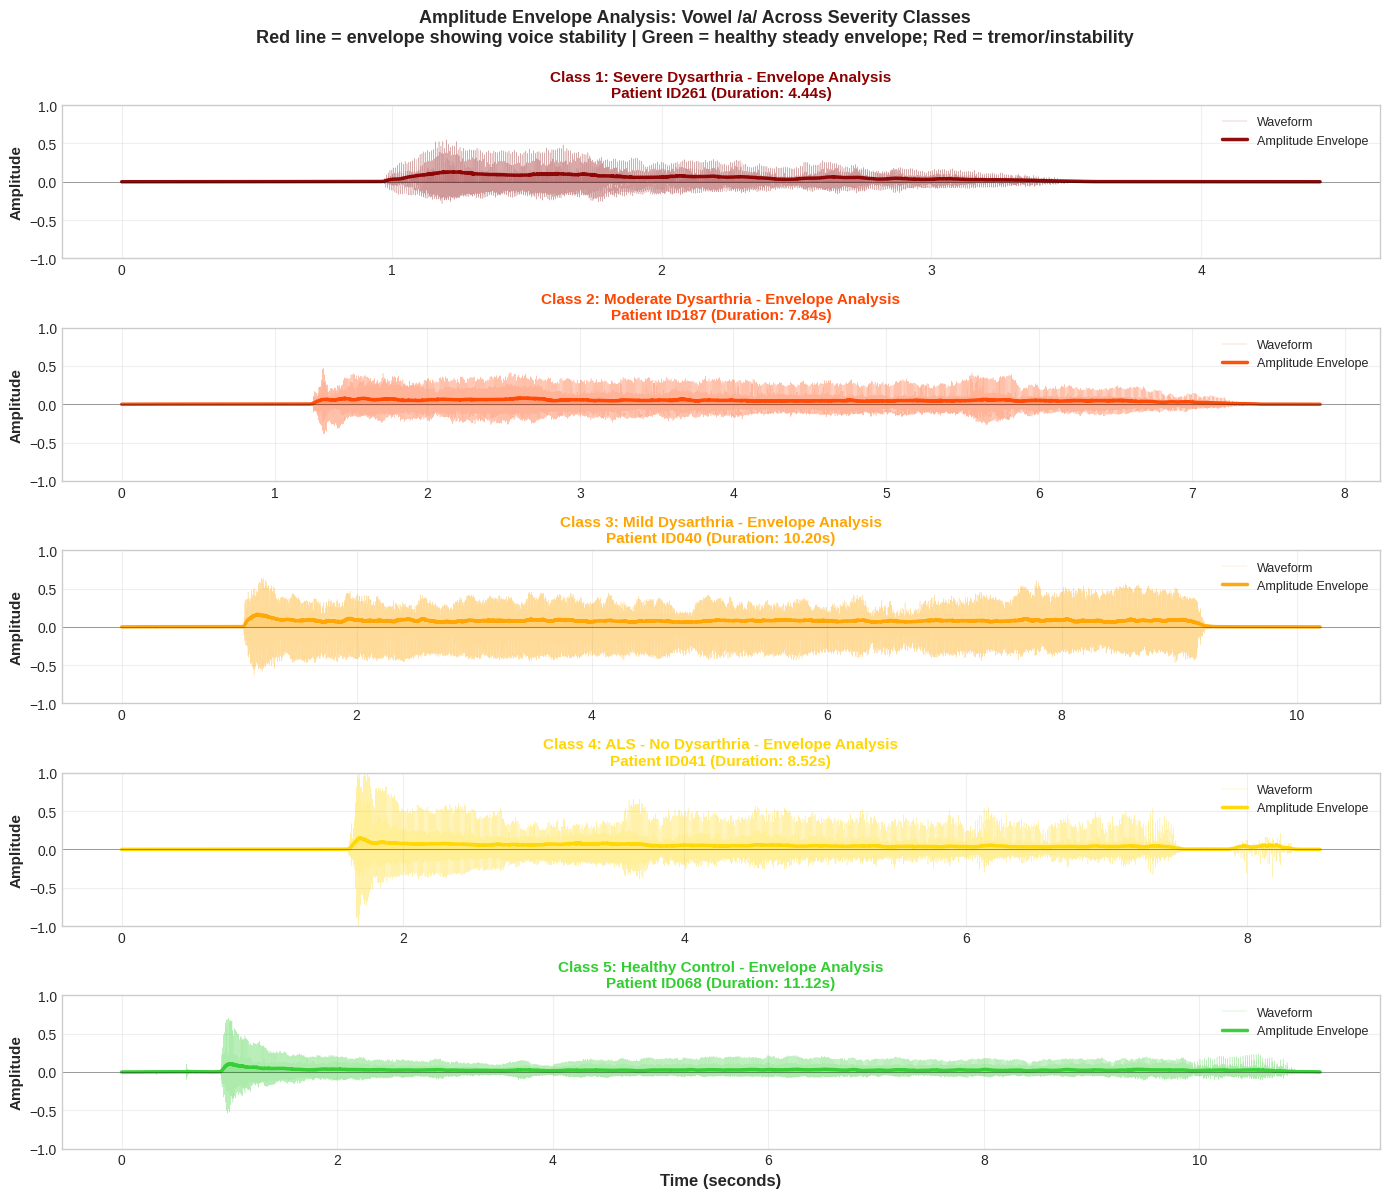

✅ Plot 3 saved: plot3_amplitude_envelope_analysis.pdf


In [16]:
print("\n🔊 Creating Plot 3: Amplitude Envelope Analysis...")

# Extract amplitude envelope for each class
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

colors = ['#8B0000', '#FF4500', '#FFA500', '#FFD700', '#32CD32']

for idx, cls in enumerate(range(1, 6)):
    patient_id = sample_patients[cls]
    audio_path = os.path.join(DATA_PATH, 'training', 'phonationA', f"{patient_id}_phonationA.wav")

    try:
        audio, sr = librosa.load(audio_path, sr=8000)
        duration = len(audio) / sr
        time_axis = np.linspace(0, duration, len(audio))

        # Calculate amplitude envelope using absolute value
        envelope = np.abs(audio)

        # Smooth envelope with median filter
        envelope_smooth = signal.medfilt(envelope, kernel_size=501)

        # Plot waveform (light) and envelope (dark)
        axes[idx].plot(time_axis, audio, color=colors[idx], linewidth=0.3, alpha=0.4, label='Waveform')
        axes[idx].plot(time_axis, envelope_smooth, color=colors[idx], linewidth=2.5, alpha=0.95, label='Amplitude Envelope')
        axes[idx].fill_between(time_axis, envelope_smooth, alpha=0.2, color=colors[idx])

        # Format
        axes[idx].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Class {cls}: {class_names[cls]} - Envelope Analysis\n' +
                           f'Patient {patient_id} (Duration: {duration:.2f}s)',
                           fontsize=11, fontweight='bold', color=colors[idx])
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylim(-1, 1)
        axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        axes[idx].legend(loc='upper right', fontsize=9)

    except Exception as e:
        print(f"⚠️ Error for class {cls}: {e}")

axes[4].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')

fig.suptitle('Amplitude Envelope Analysis: Vowel /a/ Across Severity Classes\n' +
             'Red line = envelope showing voice stability | Green = healthy steady envelope; Red = tremor/instability',
             fontsize=13, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('plot3_amplitude_envelope_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot 3 saved: plot3_amplitude_envelope_analysis.pdf")


🔊 Creating Plot 4: Detailed Severe vs Healthy Comparison...


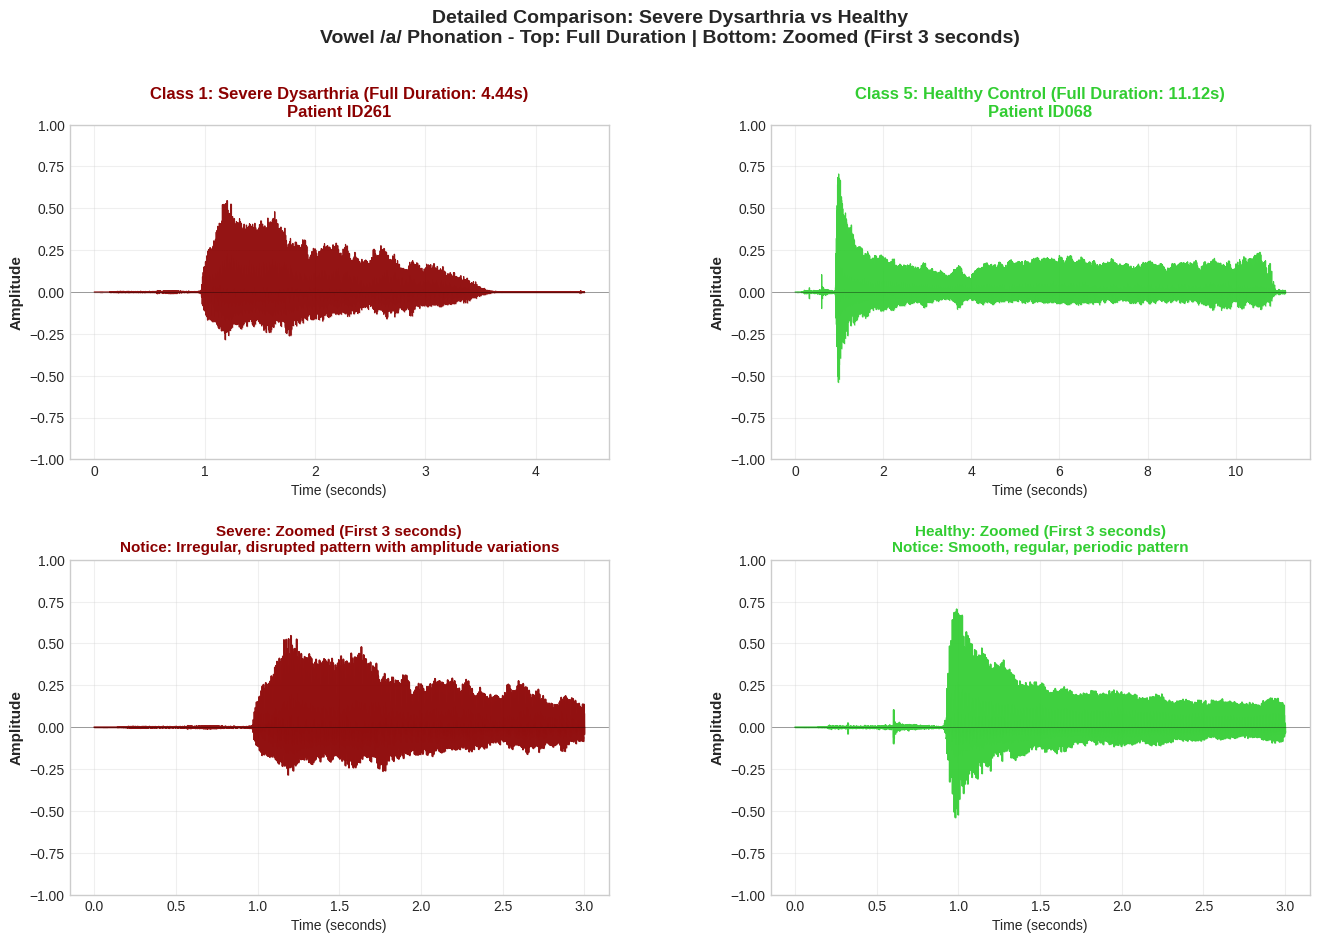

✅ Plot 4 saved: plot4_severe_vs_healthy_detailed.pdf


In [17]:
print("\n🔊 Creating Plot 4: Detailed Severe vs Healthy Comparison...")

# Get severe and healthy patients
severe_patient = sample_patients[1]
healthy_patient = sample_patients[5]

# Load both
severe_path = os.path.join(DATA_PATH, 'training', 'phonationA', f"{severe_patient}_phonationA.wav")
healthy_path = os.path.join(DATA_PATH, 'training', 'phonationA', f"{healthy_patient}_phonationA.wav")

severe_audio, sr = librosa.load(severe_path, sr=8000)
healthy_audio, sr = librosa.load(healthy_path, sr=8000)

# Create figure with 4 subplots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# ------- SEVERE: FULL DURATION -------
ax1 = fig.add_subplot(gs[0, 0])
severe_dur = len(severe_audio) / sr
severe_time_full = np.linspace(0, severe_dur, len(severe_audio))
ax1.plot(severe_time_full, severe_audio, color='#8B0000', linewidth=0.8, alpha=0.9)
ax1.fill_between(severe_time_full, severe_audio, alpha=0.2, color='#8B0000')
ax1.set_title(f'Class 1: Severe Dysarthria (Full Duration: {severe_dur:.2f}s)\nPatient {severe_patient}',
             fontsize=12, fontweight='bold', color='#8B0000')
ax1.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
ax1.set_xlabel('Time (seconds)', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1, 1)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# ------- HEALTHY: FULL DURATION -------
ax2 = fig.add_subplot(gs[0, 1])
healthy_dur = len(healthy_audio) / sr
healthy_time_full = np.linspace(0, healthy_dur, len(healthy_audio))
ax2.plot(healthy_time_full, healthy_audio, color='#32CD32', linewidth=0.8, alpha=0.9)
ax2.fill_between(healthy_time_full, healthy_audio, alpha=0.2, color='#32CD32')
ax2.set_title(f'Class 5: Healthy Control (Full Duration: {healthy_dur:.2f}s)\nPatient {healthy_patient}',
             fontsize=12, fontweight='bold', color='#32CD32')
ax2.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
ax2.set_xlabel('Time (seconds)', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-1, 1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# ------- SEVERE: ZOOMED (First 3 seconds) -------
ax3 = fig.add_subplot(gs[1, 0])
zoom_samples_severe = min(sr * 3, len(severe_audio))
severe_zoom_time = np.linspace(0, zoom_samples_severe/sr, zoom_samples_severe)
severe_zoom = severe_audio[:zoom_samples_severe]
ax3.plot(severe_zoom_time, severe_zoom, color='#8B0000', linewidth=1.2, alpha=0.9)
ax3.fill_between(severe_zoom_time, severe_zoom, alpha=0.3, color='#8B0000')
ax3.set_title('Severe: Zoomed (First 3 seconds)\nNotice: Irregular, disrupted pattern with amplitude variations',
             fontsize=11, fontweight='bold', color='#8B0000')
ax3.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
ax3.set_xlabel('Time (seconds)', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-1, 1)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# ------- HEALTHY: ZOOMED (First 3 seconds) -------
ax4 = fig.add_subplot(gs[1, 1])
zoom_samples_healthy = min(sr * 3, len(healthy_audio))
healthy_zoom_time = np.linspace(0, zoom_samples_healthy/sr, zoom_samples_healthy)
healthy_zoom = healthy_audio[:zoom_samples_healthy]
ax4.plot(healthy_zoom_time, healthy_zoom, color='#32CD32', linewidth=1.2, alpha=0.9)
ax4.fill_between(healthy_zoom_time, healthy_zoom, alpha=0.3, color='#32CD32')
ax4.set_title('Healthy: Zoomed (First 3 seconds)\nNotice: Smooth, regular, periodic pattern',
             fontsize=11, fontweight='bold', color='#32CD32')
ax4.set_ylabel('Amplitude', fontsize=11, fontweight='bold')
ax4.set_xlabel('Time (seconds)', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(-1, 1)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

fig.suptitle('Detailed Comparison: Severe Dysarthria vs Healthy\n' +
             'Vowel /a/ Phonation - Top: Full Duration | Bottom: Zoomed (First 3 seconds)',
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('plot4_severe_vs_healthy_detailed.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot 4 saved: plot4_severe_vs_healthy_detailed.pdf")

In [18]:
print("\n📊 Calculating Audio Quality Metrics...")

# Function to extract quality metrics
def extract_metrics(audio, sr):
    """Extract various audio quality metrics"""

    # 1. Signal energy
    energy = np.mean(audio ** 2)

    # 2. Zero crossing rate (voice stability)
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))

    # 3. RMS (root mean square)
    rms = np.sqrt(np.mean(audio ** 2))

    # 4. Peak amplitude
    peak = np.max(np.abs(audio))

    # 5. Crest factor (peak to RMS ratio)
    crest_factor = peak / rms if rms > 0 else 0

    # 6. Spectral centroid (average frequency)
    S = np.abs(librosa.stft(audio))
    freq = np.fft.rfftfreq(len(audio), 1/sr)
    mag = np.mean(S, axis=1)
    spectral_centroid = np.sum(freq[:len(mag)] * mag) / np.sum(mag)

    return {
        'energy': energy,
        'zcr': zcr,
        'rms': rms,
        'peak': peak,
        'crest_factor': crest_factor,
        'spectral_centroid': spectral_centroid
    }

# Calculate metrics for sample patients
metrics_data = []

for cls in range(1, 6):
    patient_id = sample_patients[cls]
    audio_path = os.path.join(DATA_PATH, 'training', 'phonationA', f"{patient_id}_phonationA.wav")

    try:
        audio, sr = librosa.load(audio_path, sr=8000)
        metrics = extract_metrics(audio, sr)
        metrics['Class'] = cls
        metrics['Patient_ID'] = patient_id
        metrics_data.append(metrics)
    except Exception as e:
        print(f"⚠️ Error for class {cls}: {e}")

metrics_df = pd.DataFrame(metrics_data)

print("✅ Metrics calculated!")
print("\n📊 Audio Quality Metrics by Class:")
print(metrics_df.round(4))


📊 Calculating Audio Quality Metrics...
✅ Metrics calculated!

📊 Audio Quality Metrics by Class:
   energy     zcr     rms    peak  crest_factor  spectral_centroid  Class  \
0  0.0051  0.1596  0.0717  0.5466        7.6225            64.5903      1   
1  0.0063  0.1772  0.0793  0.4718        5.9522            42.0368      2   
2  0.0172  0.1705  0.1312  0.6361        4.8481            22.8606      3   
3  0.0088  0.1809  0.0936  1.0000       10.6833            37.4184      4   
4  0.0024  0.1643  0.0485  0.7050       14.5366            26.2086      5   

  Patient_ID  
0      ID261  
1      ID187  
2      ID040  
3      ID041  
4      ID068  


In [19]:
print("\n" + "="*80)
print("📊 WAVEFORM & SIGNAL QUALITY ANALYSIS SUMMARY")
print("="*80)

print("\n1. WAVEFORM CHARACTERISTICS BY SEVERITY:")
print("-" * 80)

for cls in range(1, 6):
    patient_id = sample_patients[cls]
    audio_path = os.path.join(DATA_PATH, 'training', 'phonationA', f"{patient_id}_phonationA.wav")
    audio, sr = librosa.load(audio_path, sr=8000)
    duration = len(audio) / sr

    print(f"\nClass {cls} ({class_names[cls]}) - Patient {patient_id}:")
    print(f"  • Duration: {duration:.2f} seconds")
    print(f"  • Peak amplitude: {np.max(np.abs(audio)):.4f}")
    print(f"  • RMS energy: {np.sqrt(np.mean(audio**2)):.4f}")

print("\n2. AUDIO QUALITY METRICS:")
print("-" * 80)
print(metrics_df[['Class', 'Patient_ID', 'energy', 'zcr', 'rms', 'spectral_centroid']].round(4))

print("\n3. KEY OBSERVATIONS:")
print("-" * 80)
print("""
✓ Healthy subjects show:
  - Smooth, regular waveform patterns
  - Consistent amplitude throughout recording
  - Periodic oscillations indicating stable phonation
  - Low amplitude variability

✗ Severe dysarthria shows:
  - Irregular, chaotic waveform patterns
  - Variable amplitude (tremor, weakness)
  - Disrupted periodicity with gaps
  - High amplitude variability
  - Noise-like characteristics

→ Progressive degradation from Class 5 to Class 1
  - Waveform regularity decreases with severity
  - Amplitude variability increases with severity
""")

print("\n" + "="*80)


📊 WAVEFORM & SIGNAL QUALITY ANALYSIS SUMMARY

1. WAVEFORM CHARACTERISTICS BY SEVERITY:
--------------------------------------------------------------------------------

Class 1 (Severe Dysarthria) - Patient ID261:
  • Duration: 4.44 seconds
  • Peak amplitude: 0.5466
  • RMS energy: 0.0717

Class 2 (Moderate Dysarthria) - Patient ID187:
  • Duration: 7.84 seconds
  • Peak amplitude: 0.4718
  • RMS energy: 0.0793

Class 3 (Mild Dysarthria) - Patient ID040:
  • Duration: 10.20 seconds
  • Peak amplitude: 0.6361
  • RMS energy: 0.1312

Class 4 (ALS - No Dysarthria) - Patient ID041:
  • Duration: 8.52 seconds
  • Peak amplitude: 1.0000
  • RMS energy: 0.0936

Class 5 (Healthy Control) - Patient ID068:
  • Duration: 11.12 seconds
  • Peak amplitude: 0.7050
  • RMS energy: 0.0485

2. AUDIO QUALITY METRICS:
--------------------------------------------------------------------------------
   Class Patient_ID  energy     zcr     rms  spectral_centroid
0      1      ID261  0.0051  0.1596  0.0717